# Data Cleaning and Regression on BigMart Data in R
*Kritik Seth*

This dataset contains information about BigMart a nation wide supermarket chain. Bigmart's board of directors have given a challenge to all the data scientists stating to create a model that can predict the sales, per product, for each store. BigMart has collected sales data from the year 2013, for 1559 products across 10 stores in different cities. With this information the corporation hopes we can identify the products and stores which play a key role in their sales and use that information to take the correct measures to ensure success of their business.

As an aspiring data scientist, understanding how to clean and model data like this is of great importance to me. In this kernel, I will use the BigMart data clean it and explore which factors affect the Item_Outlet_Sales. I will perform a regression analysis on the same.


#### BigMart Data

The data has following features, Item_Outlet_Sales being the target (dependent) variable:

* Item_Identifier: Unique product ID
* Item_Weight: Weight of the product
* Item_Fat_Content: Levels of fat in different types of food
* Item_Visibility: The total display area allocated to a product in each store
* Item_Type: The category to which the product belongs
* Item_MRP: Maximum Retail Price (list price) of the product
* Outlet_Identifier: Unique store ID
* Outlet_Establishment_Year: The year in which store was established
* Outlet_Size: The size of the store
* Outlet_Location_Type: The type of city in which the store is located
* Outlet_Type: What type of supermarket is the store
* Item_Outlet_Sales: Sales of the product in that particular store

### We will structure the code as follows:
1. Loading the data
2. Exploratory Data Analysis (EDA) and Data Preparation
4. Regression


#### Libraries required-

In [1]:
library(nnet) #for multiple regression
library(dplyr) #for data cleaning
library(caret) #for trainiing the model
library(glmnet) #for lasso regression
library(Amelia) #for predictive imputatin
library(stringr) #for slicing character variables
library(ggplot2) #for visualisation
library(mltools) #for one hot encoding
library(corrplot) #for plotting a correlation graph
library(tidyverse) #for data cleaning
library(data.table) #for data manupulation


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: lattice

Loading required package: ggplot2


Attaching package: ‘caret’


The following object is masked from ‘package:httr’:

    progress


Loading required package: Matrix

Loaded glmnet 3.0-2


Loading required package: Rcpp

## 
## Amelia II: Multiple Imputation
## (Version 1.7.6, built: 2019-11-24)
## Copyright (C) 2005-2020 James Honaker, Gary King and Matthew Blackwell
## Refer to http://gking.harvard.edu/amelia/ for more information
## 

corrplot 0.84 loaded

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ tibble  2.1.3     ✔ readr   1.3.1
✔ tidyr   1.0.2     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand()     masks 

### 1. Loading the data

In [2]:
train <- read.csv('../input/bigmart-sales-data/Train.csv',header = T,na.strings = c('',' '))
test <- read.csv('../input/bigmart-sales-data/Test.csv',header = T,na.strings = c('',' '))

In read.csv-
* header is a logical value indicating whether the file contains the names of the variables as its first line.
* na.strings = c() is a character vector of strings which are to be interpreted as NA values, therefore any blank cells/spaces will be considered as NA.

#### For any further analysis and cleaning we will combine the testing and training data

In [3]:
dim(train); dim(test)
test$Item_Outlet_Sales <- NA #Setting the response variable in test dataset to NA
bigmart <- suppressWarnings(bind_rows(train,test))
dim(bigmart)

[1] 8523   12

[1] 5681   11

[1] 14204    12

#### Previewing the data

In [4]:
head(bigmart)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
,<chr>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<int>,<fct>,<fct>,<fct>,<dbl>
1,FDA15,9.300,Low Fat,0.01604730,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
2,DRC01,5.920,Regular,0.01927822,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
3,FDN15,17.500,Low Fat,0.01676007,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
4,FDX07,19.200,Regular,0.00000000,Fruits and Vegetables,182.0950,OUT010,1998,NA,Tier 3,Grocery Store,732.3800
5,NCD19,8.930,Low Fat,0.00000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
6,FDP36,10.395,Regular,0.00000000,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088


In [5]:
str(bigmart)

'data.frame':	14204 obs. of  12 variables:
 $ Item_Identifier          : chr  "FDA15" "DRC01" "FDN15" "FDX07" ...
 $ Item_Weight              : num  9.3 5.92 17.5 19.2 8.93 ...
 $ Item_Fat_Content         : Factor w/ 5 levels "LF","low fat",..: 3 5 3 5 3 5 5 3 5 5 ...
 $ Item_Visibility          : num  0.016 0.0193 0.0168 0 0 ...
 $ Item_Type                : Factor w/ 16 levels "Baking Goods",..: 5 15 11 7 10 1 14 14 6 6 ...
 $ Item_MRP                 : num  249.8 48.3 141.6 182.1 53.9 ...
 $ Outlet_Identifier        : Factor w/ 10 levels "OUT010","OUT013",..: 10 4 10 1 2 4 2 6 8 3 ...
 $ Outlet_Establishment_Year: int  1999 2009 1999 1998 1987 2009 1987 1985 2002 2007 ...
 $ Outlet_Size              : Factor w/ 3 levels "High","Medium",..: 2 2 2 NA 1 2 1 2 NA NA ...
 $ Outlet_Location_Type     : Factor w/ 3 levels "Tier 1","Tier 2",..: 1 3 1 3 3 3 3 3 2 2 ...
 $ Outlet_Type              : Factor w/ 4 levels "Grocery Store",..: 2 3 2 1 2 3 2 4 2 2 ...
 $ Item_Outlet_Sales        : nu

Creating a function which gives us all the necessary details needed for data cleaning and preparation in one place.

In [6]:
dataInfo <- function(df) {
  NAvalues <- list(); NAclass <- list(); UniqueVals <- list(); ColName <- names(df); Index <- c(1:dim(df)[2])
  for(i in 1:dim(df)[2]) {
    NAvalues[i] <- sum(is.na(df[,i]))
    NAclass[i] <- class(df[,i])
    if(class(df[,i])=="numeric" | class(df[,i])=="integer") {
      UniqueVals[i] <- 'Not Applicable'
    }
    else{
      UniqueVals[i] <- length(unique(df[,i]))
    }
  }
  NAlist <- cbind(Index,ColName,NAvalues,NAclass,UniqueVals) 
}

Info <- dataInfo(bigmart); Info

Index ColName                   NAvalues NAclass   UniqueVals    
 [1,] 1     Item_Identifier           0        character 1559          
 [2,] 2     Item_Weight               2439     numeric   Not Applicable
 [3,] 3     Item_Fat_Content          0        factor    5             
 [4,] 4     Item_Visibility           0        numeric   Not Applicable
 [5,] 5     Item_Type                 0        factor    16            
 [6,] 6     Item_MRP                  0        numeric   Not Applicable
 [7,] 7     Outlet_Identifier         0        factor    10            
 [8,] 8     Outlet_Establishment_Year 0        integer   Not Applicable
 [9,] 9     Outlet_Size               4016     factor    4             
[10,] 10    Outlet_Location_Type      0        factor    3             
[11,] 11    Outlet_Type               0        factor    4             
[12,] 12    Item_Outlet_Sales         5681     numeric   Not Applicable

### Basic Analysis from Variable names and data previewing

One can conclude that the variables in this dataset may be divided into two categories-
* 'Item' Related (Item_Identifier, Item_Weight, Item_Fat_Content, Item_Visibility, Item_Type, Item_MRP)
* 'Outlet' Related (Outlet_Identifier, Outler_Establishment_Year, Outlet_Size, Outlet_Location_Type, Outlet_Type)

### We will deal with one variable at a time

#### 1. Item_Identifier


In [7]:
head(table(bigmart$Item_Identifier))
min(table(bigmart$Item_Identifier))
bigmart$Item_Identifier <- as.factor(bigmart$Item_Identifier)


DRA12 DRA24 DRA59 DRB01 DRB13 DRB24 
    9    10    10     8     9     8 

[1] 7

On taking a deeper look at the Item_Identifier variable we notice the following-

1. The first two letters in the Item_Identifier are of three types- 'DR', 'FD' and 'NC'.These should stand for 'Drinks', 'Food' and 'Non Consumable' respectively.
2. The third letter which ranges from A - Z could stand for subcategories in a product Type.
3. The numbers in Item_Identifier could stand for a unique ID assigned to a product in a category.

Since the second. and third obsevation are somewhat similar to unique ID for each product and it is difficult to get some meaning out of it we will only look into the first observation.

We will try create a new column for Item Category.

In [8]:
bigmart$Item_Category <- str_sub(bigmart$Item_Identifier,start = 1L, end = 2L)
bigmart$Item_Category <- as.factor(bigmart$Item_Category)
head(bigmart$Item_Category)

[1] FD DR FD FD NC FD
Levels: DR FD NC

#### 2. Item_Weight

From above we can infer that every product in the dataset appears atleast 7 times. From common knowledge we know that product's weight remains same be it any sample. Therefore we can impute the missing value in Item_Weight with the weight of same product as identified by Item_Identifier.

In [9]:
imputeWeight <- function(df) {
  df %>%
    group_by(Item_Identifier) %>%
    mutate(Item_Weight = ifelse(is.na(Item_Weight),mean(Item_Weight,na.rm = T),Item_Weight)) %>%
    ungroup()
}

Identify_Weight <- bigmart[,c(1,2)]
Identify_Weight <- imputeWeight(Identify_Weight)
bigmart[,c(1,2)] <- Identify_Weight

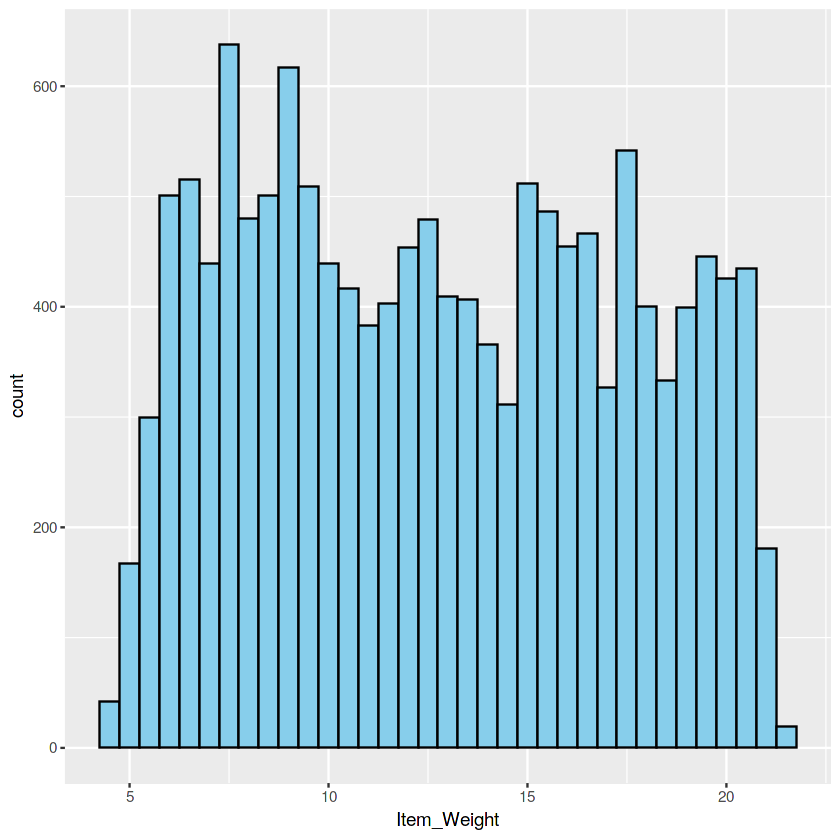

In [10]:
ggplot(bigmart) + geom_histogram(aes(Item_Weight),binwidth = 0.5,fill = 'skyblue', col = 'black')

From the above graph no noticeable skewness pattern is visible hence no transformation is needed.

In [11]:
Info <- dataInfo(bigmart); Info

Index ColName                   NAvalues NAclass UniqueVals    
 [1,] 1     Item_Identifier           0        factor  1559          
 [2,] 2     Item_Weight               0        numeric Not Applicable
 [3,] 3     Item_Fat_Content          0        factor  5             
 [4,] 4     Item_Visibility           0        numeric Not Applicable
 [5,] 5     Item_Type                 0        factor  16            
 [6,] 6     Item_MRP                  0        numeric Not Applicable
 [7,] 7     Outlet_Identifier         0        factor  10            
 [8,] 8     Outlet_Establishment_Year 0        integer Not Applicable
 [9,] 9     Outlet_Size               4016     factor  4             
[10,] 10    Outlet_Location_Type      0        factor  3             
[11,] 11    Outlet_Type               0        factor  4             
[12,] 12    Item_Outlet_Sales         5681     numeric Not Applicable
[13,] 13    Item_Category             0        factor  3

As we can see that Item_Weight has zero NA values now!

#### 3. Item_Fat_Content

In [12]:
glimpse(bigmart$Item_Fat_Content)
unique(bigmart$Item_Fat_Content)

 Factor w/ 5 levels "LF","low fat",..: 3 5 3 5 3 5 5 3 5 5 ...


[1] Low Fat Regular low fat LF      reg    
Levels: LF low fat Low Fat reg Regular

As we can see that Item_Fat_Content has redundant variables, the ideal levels should be:
* 'LF', 'low fat' and 'Low Fat'  -> 'Low Fat'
* 'reg' and 'Regular' -> 'Regular'

In [13]:
levels(bigmart$Item_Fat_Content) <- list('Low Fat' = 'LF','Low Fat' = 'low fat','Regular'='reg')
unique(bigmart$Item_Fat_Content)

[1] Low Fat Regular
Levels: Low Fat Regular

As we found out during the analysis of Item_Identifier Variable, some products are Non Consumable hence we will replace the fat content in those rows by 'Not Consumable'.

In [14]:
NC <- as.data.table(bigmart[,c(3,13)])
NC[Item_Category=='NC',Item_Fat_Content:='Non Consumable',Item_Fat_Content]
bigmart[,c(3,13)] <- NC

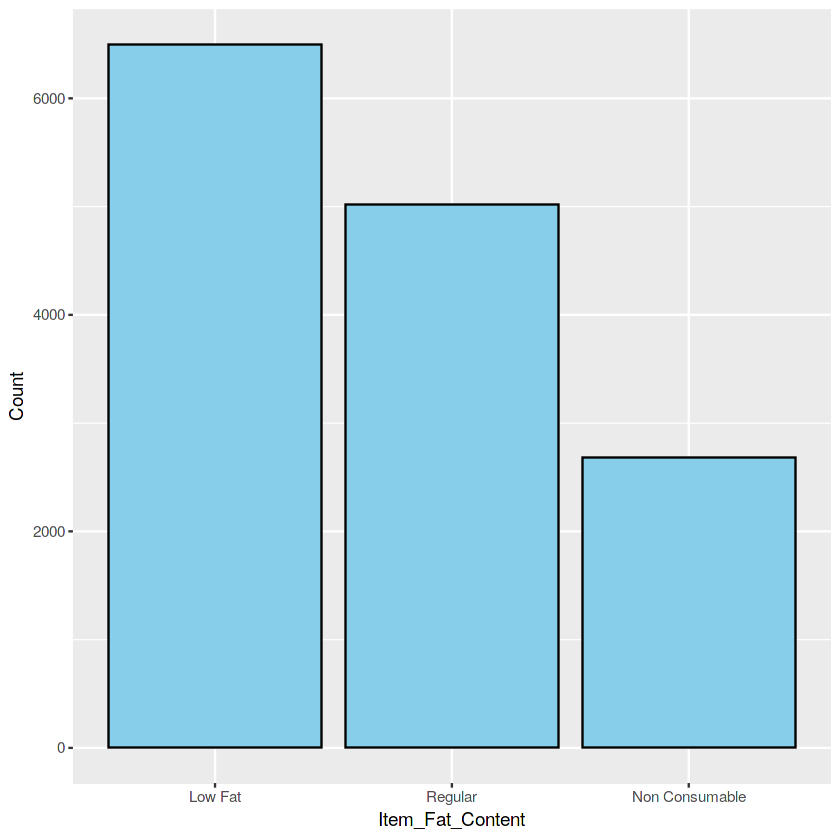

In [15]:
ggplot(bigmart %>% group_by(Item_Fat_Content) %>% summarise(Count = n())) + 
  geom_bar(aes(Item_Fat_Content, Count), stat = 'identity', fill = 'skyblue',col = 'black')

In [16]:
Info <- dataInfo(bigmart); Info

Index ColName                   NAvalues NAclass UniqueVals    
 [1,] 1     Item_Identifier           0        factor  1559          
 [2,] 2     Item_Weight               0        numeric Not Applicable
 [3,] 3     Item_Fat_Content          0        factor  3             
 [4,] 4     Item_Visibility           0        numeric Not Applicable
 [5,] 5     Item_Type                 0        factor  16            
 [6,] 6     Item_MRP                  0        numeric Not Applicable
 [7,] 7     Outlet_Identifier         0        factor  10            
 [8,] 8     Outlet_Establishment_Year 0        integer Not Applicable
 [9,] 9     Outlet_Size               4016     factor  4             
[10,] 10    Outlet_Location_Type      0        factor  3             
[11,] 11    Outlet_Type               0        factor  4             
[12,] 12    Item_Outlet_Sales         5681     numeric Not Applicable
[13,] 13    Item_Category             0        factor  3

#### 4. Item_Visibility

I noticed while pre-viewing the data that few rows in Item_Visibility are zero and it doesn't make sense for an item to be occupying shelf space and yet have zero visibility.
Hence we conclude that this is erraneous data.

We know that every product in the dataset appears atleast 7 times. A particular product has to have similar visibility because of its appearance, be it in any outlet. Therefore we will impute the 0 values in Item_Visibility with the mean visibiility of same product as identified by Item_Identifier.

In [17]:
bigmart[,4][bigmart[,4]==0] <- NA

imputeFat <- function(df) {
  df %>%
    group_by(Item_Identifier) %>% 
    mutate(Item_Visibility = ifelse(is.na(Item_Visibility),mean(Item_Visibility,na.rm=T),Item_Visibility)) %>%
    ungroup()
}

Vis <- bigmart[,c(1,4,5)]
Vis <- imputeFat(Vis)
bigmart[,c(1,4,5)] <- Vis

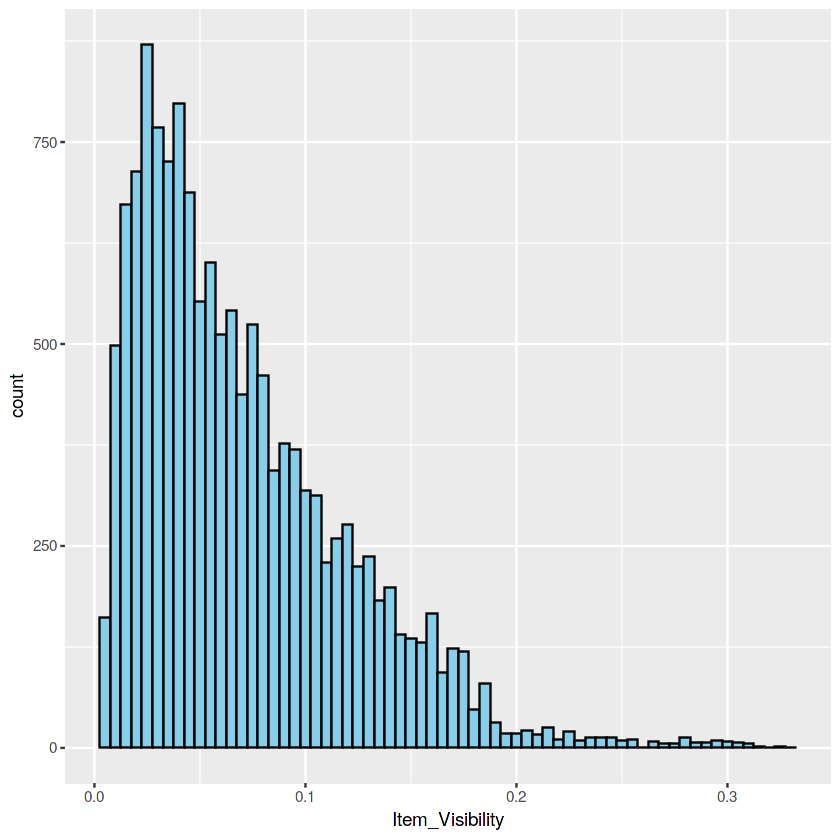

In [18]:
ggplot(bigmart) + geom_histogram(aes(Item_Visibility),binwidth = 0.005, fill = 'skyblue', col = 'black')

As we see Item_Visibility is right skewed hence we will have to tranform the data.

In [19]:
Info <- dataInfo(bigmart); Info

Index ColName                   NAvalues NAclass UniqueVals    
 [1,] 1     Item_Identifier           0        factor  1559          
 [2,] 2     Item_Weight               0        numeric Not Applicable
 [3,] 3     Item_Fat_Content          0        factor  3             
 [4,] 4     Item_Visibility           0        numeric Not Applicable
 [5,] 5     Item_Type                 0        factor  16            
 [6,] 6     Item_MRP                  0        numeric Not Applicable
 [7,] 7     Outlet_Identifier         0        factor  10            
 [8,] 8     Outlet_Establishment_Year 0        integer Not Applicable
 [9,] 9     Outlet_Size               4016     factor  4             
[10,] 10    Outlet_Location_Type      0        factor  3             
[11,] 11    Outlet_Type               0        factor  4             
[12,] 12    Item_Outlet_Sales         5681     numeric Not Applicable
[13,] 13    Item_Category             0        factor  3

#### 5. Outlet_Size

We will now replace the NA values in Outlet_Size by predictive Imputation.

Outlet_Identifier, Outlet_Establishment_Year, Outlet_Location_Type and Outlet_Type are the only variables that the Outlet_Size should depend on hence we will use the Amelia function from Amelia library to impute the NA values in Outlet_Size.

In [20]:
sub_mart <- bigmart  %>%
  select(Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type)

sub_mart$Outlet_Identifier <- as.factor(sub_mart$Outlet_Identifier)
sub_mart$Outlet_Establishment_Year <- as.factor(sub_mart$Outlet_Establishment_Year)
sub_mart$Outlet_Size <- factor(sub_mart$Outlet_Size,levels = c("Small","Medium","High"),labels = c(1,2,3),ordered = T)
sub_mart$Outlet_Location_Type <- factor(sub_mart$Outlet_Location_Type,levels = c("Tier 3","Tier 2","Tier 1"),labels = c(3,2,1),ordered = T)
sub_mart$Outlet_Type <- as.factor(sub_mart$Outlet_Type)

In [21]:
str(sub_mart)

'data.frame':	14204 obs. of  5 variables:
 $ Outlet_Identifier        : Factor w/ 10 levels "OUT010","OUT013",..: 10 4 10 1 2 4 2 6 8 3 ...
 $ Outlet_Establishment_Year: Factor w/ 9 levels "1985","1987",..: 5 9 5 4 2 9 2 1 6 8 ...
 $ Outlet_Size              : Ord.factor w/ 3 levels "1"<"2"<"3": 2 2 2 NA 3 2 3 2 NA NA ...
 $ Outlet_Location_Type     : Ord.factor w/ 3 levels "3"<"2"<"1": 3 1 3 1 1 1 1 1 2 2 ...
 $ Outlet_Type              : Factor w/ 4 levels "Grocery Store",..: 2 3 2 1 2 3 2 4 2 2 ...


In [22]:
imputed_mart <- amelia(sub_mart, m = 5, ords = c("Outlet_Size","Outlet_Location_Type"),
                                   noms = c("Outlet_Establishment_Year", "Outlet_Identifier","Outlet_Type"),
                                   incheck = TRUE,empri = 1)

Warning message in amcheck(x = x, m = m, idvars = numopts$idvars, priors = priors, :
“The variables (or variable with levels) Outlet_Establishment_Year1987, Outlet_Establishment_Year1997, Outlet_Establishment_Year1999, Outlet_Establishment_Year2004, Outlet_Establishment_Year2009, Outlet_Size.L, Outlet_Size.Q, Outlet_Location_Type.L, Outlet_Location_Type.Q, Outlet_TypeSupermarket Type1, Outlet_TypeSupermarket Type2, Outlet_TypeSupermarket Type3 are perfectly collinear with another variable in the data.
”


-- Imputation 1 --

  1  2  3  4  5  6  7  8  9

-- Imputation 2 --

  1  2  3  4  5  6  7  8

-- Imputation 3 --

  1  2  3  4  5  6  7  8

-- Imputation 4 --

  1  2  3  4  5  6  7  8

-- Imputation 5 --

  1  2  3  4  5  6  7  8  9



In [23]:
fit1 <- multinom(Outlet_Size~Outlet_Location_Type+Outlet_Establishment_Year+Outlet_Identifier+Outlet_Type,data = imputed_mart$imputations$imp1)
fit2 <- multinom(Outlet_Size~Outlet_Location_Type+Outlet_Establishment_Year+Outlet_Identifier+Outlet_Type,data = imputed_mart$imputations$imp2)
fit3 <- multinom(Outlet_Size~Outlet_Location_Type+Outlet_Establishment_Year+Outlet_Identifier+Outlet_Type,data = imputed_mart$imputations$imp3)
fit4 <- multinom(Outlet_Size~Outlet_Location_Type+Outlet_Establishment_Year+Outlet_Identifier+Outlet_Type,data = imputed_mart$imputations$imp4)
fit5 <- multinom(Outlet_Size~Outlet_Location_Type+Outlet_Establishment_Year+Outlet_Identifier+Outlet_Type,data = imputed_mart$imputations$imp5)

# weights:  72 (46 variable)
initial  value 15604.688948 
iter  10 value 5793.518203
iter  20 value 4940.042930
iter  30 value 3995.755758
iter  40 value 3990.168567
iter  50 value 3989.703413
final  value 3989.702606 
converged
# weights:  72 (46 variable)
initial  value 15604.688948 
iter  10 value 5910.722875
iter  20 value 4625.534504
iter  30 value 4022.424320
iter  40 value 4018.179946
iter  50 value 4017.818802
final  value 4017.818033 
converged
# weights:  72 (46 variable)
initial  value 15604.688948 
iter  10 value 5809.117803
iter  20 value 4762.427342
iter  30 value 4023.973187
iter  40 value 4019.656017
iter  50 value 4019.433098
final  value 4019.432895 
converged
# weights:  72 (46 variable)
initial  value 15604.688948 
iter  10 value 5880.656033
iter  20 value 4732.273912
iter  30 value 4048.338781
iter  40 value 4039.298036
iter  50 value 4039.238750
final  value 4039.222212 
converged
# weights:  72 (46 variable)
initial  value 15604.688948 
iter  10 value 5912.536255

In [24]:
anova(fit1,fit2,fit3,fit4,fit5,test = "Chisq")

Model,Resid. df,Resid. Dev,Test,Df,LR stat.,Pr(Chi)
<fct>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>
Outlet_Location_Type + Outlet_Establishment_Year + Outlet_Identifier + Outlet_Type,28388,7979.405,,NA,NA,NA
Outlet_Location_Type + Outlet_Establishment_Year + Outlet_Identifier + Outlet_Type,28388,8035.636,1 vs 2,0,-56.230853,1
Outlet_Location_Type + Outlet_Establishment_Year + Outlet_Identifier + Outlet_Type,28388,8038.866,2 vs 3,0,-3.229725,1
Outlet_Location_Type + Outlet_Establishment_Year + Outlet_Identifier + Outlet_Type,28388,8078.444,3 vs 4,0,-39.578633,1
Outlet_Location_Type + Outlet_Establishment_Year + Outlet_Identifier + Outlet_Type,28388,8098.333,4 vs 5,0,-19.888910,1


While writing this notebook, 4th imputation appeared to be the best one from the above statistics, hence I have used the fourth imputation.

Warning message:
“Factor `Outlet_Size` contains implicit NA, consider using `forcats::fct_explicit_na`”


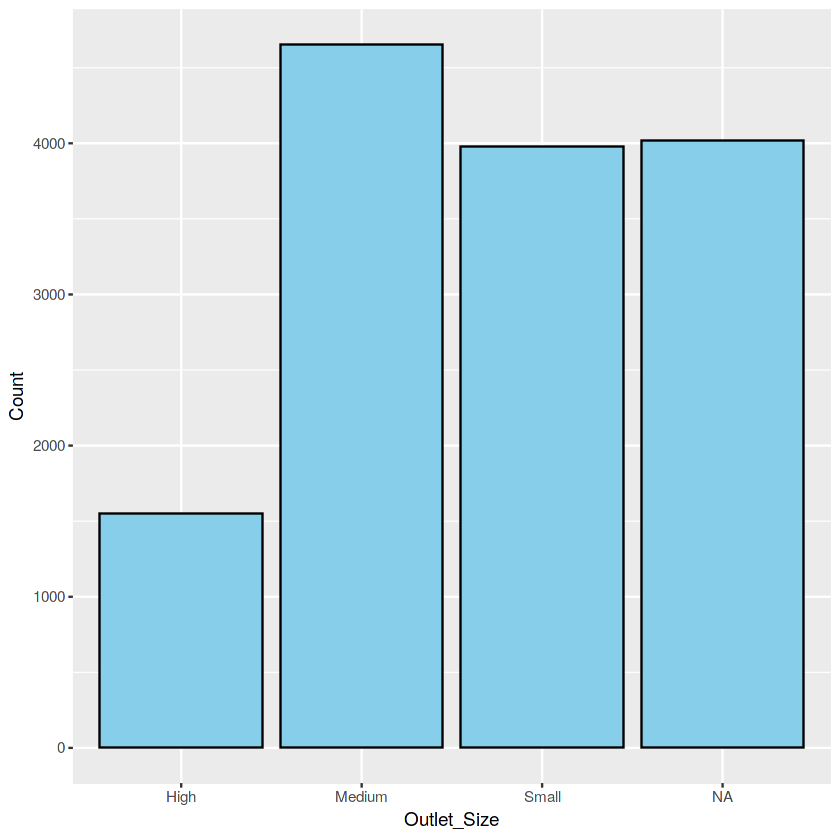

In [25]:
ggplot(bigmart %>% group_by(Outlet_Size) %>% summarise(Count = n())) + 
  geom_bar(aes(Outlet_Size, Count), stat = 'identity', fill = 'skyblue',col = 'black')

In [26]:
bigmart$Outlet_Size <- imputed_mart$imputations$imp4$Outlet_Size

### Feature Engineering

On analysis of the variables and common knowledge we know that most products are sold at a base rate (which is usually with respect to a base weight).
Hence here we will create a new variable which tells us about the Price of the Item per unit Weight.

In [27]:
bigmart$Item_Price_Weight <- bigmart$Item_MRP / bigmart$Item_Weight

We know that people only shop at the place they may have been to earlier as well. Hence we will create a varriable which has the information about the Years of Operation of each store. Since this data is from 2013 we will calculate operational years with 2013.

In [28]:
bigmart$Outlet_Operational_Years <- 2013 - bigmart$Outlet_Establishment_Year

In [29]:
Info <- dataInfo(bigmart); Info

Warning message in NAclass[i] <- class(df[, i]):
“number of items to replace is not a multiple of replacement length”
Warning message in if (class(df[, i]) == "numeric" | class(df[, i]) == "integer") {:
“the condition has length > 1 and only the first element will be used”


Index ColName                   NAvalues NAclass UniqueVals    
 [1,] 1     Item_Identifier           0        factor  1559          
 [2,] 2     Item_Weight               0        numeric Not Applicable
 [3,] 3     Item_Fat_Content          0        factor  3             
 [4,] 4     Item_Visibility           0        numeric Not Applicable
 [5,] 5     Item_Type                 0        factor  16            
 [6,] 6     Item_MRP                  0        numeric Not Applicable
 [7,] 7     Outlet_Identifier         0        factor  10            
 [8,] 8     Outlet_Establishment_Year 0        integer Not Applicable
 [9,] 9     Outlet_Size               0        ordered 3             
[10,] 10    Outlet_Location_Type      0        factor  3             
[11,] 11    Outlet_Type               0        factor  4             
[12,] 12    Item_Outlet_Sales         5681     numeric Not Applicable
[13,] 13    Item_Category             0        factor  3             
[14,] 14    Item_Price_Weight         0        numeric Not Applicable
[15,] 15    Outlet_Operational_Years  0        numeric Not Applicable

### Encoding the Variables
Machine learning algorithms and deep learning neural networks require that input and output variables are numbers.
This means that categorical data must be encoded to numbers before we can use it to fit and evaluate a model.
There are many ways to encode categorical variables for modelling, although the most common are as follows:

1. Label Encoding: Where each label is converted to a unique number (for Ordinal Variables)
2. One Hot Encoding: Where each label is mapped to a binary vector (for Nominal Variables)


#### Label Encoding
We will perform label encoding on the following variables- 'Outlet_Size', 'Outlet_Location_Type'

In [30]:
bigmart$Outlet_Size <- ifelse(bigmart$Outlet_Size == 1, 0, ifelse(bigmart$Outlet_Size == 2, 1, 2))
bigmart$Outlet_Location_Type <- ifelse(bigmart$Outlet_Location_Type == 3, 0, ifelse(bigmart$Outlet_Location_Type == 2, 1, 2))

#### One Hot Encoding
We will perform one hot encoding on the following variables- 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Type', 'Item_Category'. 

In [31]:
ohe_var <- bigmart[,c(3,5,7,11,13)]
bigmart_ohe <- one_hot(as.data.table(ohe_var))
bigmart[,c(3,5,7,11,13)] <- NULL
bigmart <- bind_cols(bigmart,bigmart_ohe)

In [32]:
Info <- dataInfo(bigmart); Info

Index ColName                         NAvalues NAclass UniqueVals    
 [1,] 1     Item_Identifier                 0        factor  1559          
 [2,] 2     Item_Weight                     0        numeric Not Applicable
 [3,] 3     Item_Visibility                 0        numeric Not Applicable
 [4,] 4     Item_MRP                        0        numeric Not Applicable
 [5,] 5     Outlet_Establishment_Year       0        integer Not Applicable
 [6,] 6     Outlet_Size                     0        numeric Not Applicable
 [7,] 7     Outlet_Location_Type            0        numeric Not Applicable
 [8,] 8     Item_Outlet_Sales               5681     numeric Not Applicable
 [9,] 9     Item_Price_Weight               0        numeric Not Applicable
[10,] 10    Outlet_Operational_Years        0        numeric Not Applicable
[11,] 11    Item_Fat_Content_Low Fat        0        integer Not Applicable
[12,] 12    Item_Fat_Content_Regular        0        integer Not Applicable
[13,] 13    Item_Fat_Content_Non Consumable 0        integer Not Applicable
[14,] 14    Item_Type_Baking Goods          0        integer Not Applicable
[15,] 15    Item_Type_Breads                0        integer Not Applicable
[16,] 16    Item_Type_Breakfast             0        integer Not Applicable
[17,] 17    Item_Type_Canned                0        integer Not Applicable
[18,] 18    Item_Type_Dairy                 0        integer Not Applicable
[19,] 19    Item_Type_Frozen Foods          0        integer Not Applicable
[20,] 20    Item_Type_Fruits and Vegetables 0        integer Not Applicable
[21,] 21    Item_Type_Hard Drinks           0        integer Not Applicable
[22,] 22    Item_Type_Health and Hygiene    0        integer Not Applicable
[23,] 23    Item_Type_Household             0        integer Not Applicable
[24,] 24    Item_Type_Meat                  0        integer Not Applicable
[25,] 25    Item_Type_Others                0        integer Not Applicable
[26,] 26    Item_Type_Seafood               0        integer Not Applicable
[27,] 27    Item_Type_Snack Foods           0        integer Not Applicable
[28,] 28    Item_Type_Soft Drinks           0        integer Not Applicable
[29,] 29    Item_Type_Starchy Foods         0        integer Not Applicable
[30,] 30    Outlet_Identifier_OUT010        0        integer Not Applicable
[31,] 31    Outlet_Identifier_OUT013        0        integer Not Applicable
[32,] 32    Outlet_Identifier_OUT017        0        integer Not Applicable
[33,] 33    Outlet_Identifier_OUT018        0        integer Not Applicable
[34,] 34    Outlet_Identifier_OUT019        0        integer Not Applicable
[35,] 35    Outlet_Identifier_OUT027        0        integer Not Applicable
[36,] 36    Outlet_Identifier_OUT035        0        integer Not Applicable
[37,] 37    Outlet_Identifier_OUT045        0        integer Not Applicable
[38,] 38    Outlet_Identifier_OUT046        0        integer Not Applicable
[39,] 39    Outlet_Identifier_OUT049        0        integer Not Applicable
[40,] 40    Outlet_Type_Grocery Store       0        integer Not Applicable
[41,] 41    Outlet_Type_Supermarket Type1   0        integer Not Applicable
[42,] 42    Outlet_Type_Supermarket Type2   0        integer Not Applicable
[43,] 43    Outlet_Type_Supermarket Type3   0        integer Not Applicable
[44,] 44    Item_Category_DR                0        integer Not Applicable
[45,] 45    Item_Category_FD                0        integer Not Applicable
[46,] 46    Item_Category_NC                0        integer Not Applicable

#### Splitting the Data

Now we will split the data back into orignal traininig and testing

In [33]:
test <- subset(bigmart,is.na(bigmart$Item_Outlet_Sales))
train <- subset(bigmart,!is.na(bigmart$Item_Outlet_Sales))

Dividing Predictor and Response into two different variables

In [34]:
Ytrain <- train[,8]
Xtrain <- train[,-8]

### 3. Regression
Now we will apply Lassoo regression to the training data.

In [35]:
set.seed(123)
my_control = trainControl(method="cv", number=5)
Grid = expand.grid(alpha = 1, lambda = seq(11,13,by = 0.0001))
lasso_mod = train(x = train[, -c(1,8)], y = train$Item_Outlet_Sales,
                             method='glmnet', trControl= my_control, tuneGrid = Grid)

In [36]:
head(lasso_mod$results)

,alpha,lambda,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,11.0000,1129.883,0.5619019,836.4769,7.793448,0.006164546,5.248766
2,1,11.0001,1129.883,0.5619019,836.4769,7.793454,0.006164549,5.248766
3,1,11.0002,1129.883,0.5619019,836.4768,7.793461,0.006164553,5.248767
4,1,11.0003,1129.883,0.5619019,836.4768,7.793468,0.006164556,5.248767
5,1,11.0004,1129.883,0.5619019,836.4768,7.793474,0.006164560,5.248767
6,1,11.0005,1129.883,0.5619019,836.4768,7.793481,0.006164563,5.248767
7,1,11.0006,1129.883,0.5619019,836.4768,7.793487,0.006164567,5.248767
8,1,11.0007,1129.883,0.5619019,836.4768,7.793494,0.006164570,5.248767
9,1,11.0008,1129.883,0.5619019,836.4768,7.793501,0.006164574,5.248767


Predicting the 'Item_Outlet_Sales' for testing data

In [37]:
test$Item_Outlet_Sales <- predict(lasso_mod,newdata=test)

I hope you enjoyed this analysis! I think going forward it would be interesting to use a method other than lasso regression.
Comments are Welcome